<h2>Problem 2</h2>
<t> Like Homework 3. Problem 2, Build a transformer mode, for the tiny Shakespeare dataset, the data loader code is already provided.</t>

In [13]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch
import time

import matplotlib.pyplot as plt
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)

<h3>Tokenize Input Text and Create Dataset:</h3>

In [14]:
textPath = "C:/Users/aidan_000/Desktop/UNCC/Github/Intro-to-DL/datasets/text-sequences/shakespeare.txt"

with open(textPath, "r", encoding='utf-8') as file:
    text = file.read()

# Grab unique characters from the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# Create dictionaries to map characters to integers and vice versa
charToIdx = {char: i for i, char in enumerate(chars)}
idxToChar = {i: char for char, i in charToIdx.items()}

encode = lambda string: [charToIdx[c] for c in string]
decode = lambda indices: ''.join([idxToChar[idx] for idx in indices])

encoded_text = encode(text)

# print(encode('test'))
# print(decode(encode('test')))

In [15]:
def prepare_data(encoded_text, sequence_len, k, batch_size):
    sequences, targets = [], []
    for i in range(0, len(encoded_text) - sequence_len[k]):
        sequence = encoded_text[i: i+sequence_len[k]]
        target = encoded_text[i+sequence_len[k]]

        sequences.append(sequence)
        targets.append(target)

    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)

    dataset = CharacterDataset(sequences, targets)

    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size
    training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    #Create DataLoaders for train and test sets
    training_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

    return training_loader, validation_loader

class CharacterDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

<h3>Model Training and Evaluation:</h3>

In [16]:
def train_model(model, criterion, optimizer, epochs, training_loader, validation_loader, update_interval):
    
    training_losses = []
    validation_accuracies = []
    starting_time = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_train = time.time()
        
        for inputs, labels in training_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            train_output = model(inputs)
            train_loss = criterion(train_output, labels)
            running_loss += train_loss.item()
            train_loss.backward()
            optimizer.step()

        training_loss = running_loss / len(training_loader)
        training_losses.append(training_loss)
        
        end_train = time.time()
        training_time = end_train - start_train

        model.eval()
        start_valid = time.time()

        with torch.no_grad():
            total_correct = 0
            total_samples = 0
            
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                valid_output = model(inputs)
                _, predicted = torch.max(valid_output, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)
        
            validation_accuracy = total_correct / total_samples * 100
            validation_accuracies.append(validation_accuracy)

        end_valid = time.time()
        validation_time = end_valid - start_valid

        if(epoch + 1) % update_interval == 0:
            rounds_end_time = time.time()
            rounds_time = rounds_end_time - starting_time
            print('Epoch {:3d}, Time (secs) {:.2f}: Training loss {:.4f}, Validation Accuracy {:.2f}%'.format(epoch + 1, rounds_time, training_losses[-1], validation_accuracies[-1]))

    total_time = time.time() - starting_time

    print(f'\nTotal Duration: {total_time:.2f}s')
    print(f'Training Duration: {training_time:.2f}s')
    print(f'Inference Duration: {validation_time:.2f}s')

    print(f'\nFinal Training Loss: {training_losses[-1]:.4f}')
    print(f'Final Validation Accuracy: {validation_accuracies[-1]:.2f}%\n')
    
    return training_losses, validation_accuracies, training_time, validation_time


# Prediction function
def charInference(model, initial_string, sequence_len, k):
    model.eval()
    with torch.no_grad():
        # Encode the initial string
        initial_input = torch.tensor([encode(initial_string[-sequence_len[k]:])], dtype=torch.long).to(device)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        
        # Decode the predicted index
        return decode([predicted_index])

<h3>Next Character Transformer</h3>

In [17]:
class OptimusTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(OptimusTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output

<h3>Hyperparameters and Training</h3>
<t>2.1) Train the models for the sequence of 20 and 30, report and compare training loss, validation accuracy, execution time for training, and computational and mode size complexities, and compare it against RNN-based models.</t>

In [18]:
context_window = [20, 30]

learning_rate = 0.001
epochs = 10

hidden_size = 128
num_layers = 3
nhead = 2


models = []
training_losses, validation_accuracies = [], []
training_times, validation_times = [], []

for k in range(len(context_window)):
    model = OptimusTransformer(input_size=vocab_size, hidden_size=hidden_size, output_size=vocab_size, num_layers=num_layers, nhead=nhead).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    training_loader, validation_loader = prepare_data(encoded_text, context_window, k, batch_size = 32)

    train_loss, valid_accuracy, training_time, validation_time = train_model(model, criterion, optimizer, epochs, training_loader, validation_loader, update_interval=1)
    
    models.append(model)

    training_losses.append(train_loss)
    validation_accuracies.append(valid_accuracy)
    
    training_times.append(training_time)
    validation_times.append(validation_time)

Epoch   1, Time (secs) 212.07: Training loss 2.4443, Validation Accuracy 31.06%
Epoch   2, Time (secs) 415.26: Training loss 2.3427, Validation Accuracy 32.66%
Epoch   3, Time (secs) 613.08: Training loss 2.3018, Validation Accuracy 33.69%
Epoch   4, Time (secs) 808.20: Training loss 2.2832, Validation Accuracy 33.74%
Epoch   5, Time (secs) 1009.75: Training loss 2.2700, Validation Accuracy 34.17%
Epoch   6, Time (secs) 1209.50: Training loss 2.2690, Validation Accuracy 34.00%
Epoch   7, Time (secs) 1406.09: Training loss 2.2534, Validation Accuracy 34.35%
Epoch   8, Time (secs) 1603.43: Training loss 2.2509, Validation Accuracy 32.73%
Epoch   9, Time (secs) 1801.82: Training loss 2.2487, Validation Accuracy 34.55%
Epoch  10, Time (secs) 2002.96: Training loss 2.2436, Validation Accuracy 34.69%

Total Duration: 2002.96s
Training Duration: 190.01s
Inference Duration: 11.13s

Final Training Loss: 2.2436
Final Validation Accuracy: 34.69%

Epoch   1, Time (secs) 215.60: Training loss 2.470

In [19]:
Model0_stats = summary(models[0], (context_window[0], vocab_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()
Model1_stats = summary(models[1], (context_window[1], vocab_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()

print(f'\n========================================= Total Time per Model =========================================')
print(f'Model with Context of 20 Training Duration: {training_times[0]:.2f}s, Inference Duration: \t{validation_times[0]:.2f}s')
print(f'Model with Context of 30 Training Duration: {training_times[1]:.2f}s, Inference Duration: \t{validation_times[1]:.2f}s')
print(f'========================================================================================================')

print(f'\n========================================= Accuracies per Model =========================================')
print(f'Model with Context of 20  Training Loss: {training_losses[0][-1]:.4f}, Inference Accuracy: {validation_accuracies[0][-1]:.2f}%')
print(f'Model with Context of 30  Training Loss: {training_losses[1][-1]:.4f}, Inference Accuracy: {validation_accuracies[1][-1]:.2f}%')
print(f'========================================================================================================')

Layer (type (var_name))                            Kernel Shape     Output Shape     Param #          Mult-Adds
OptimusTransformer (OptimusTransformer)            --               [20, 65]         --               --
├─Embedding (embedding)                            --               [20, 65, 128]    8,320            166,400
│    └─weight                                      [128, 65]                         └─8,320
├─TransformerEncoder (transformer_encoder)         --               [20, 65, 128]    --               --
│    └─layers.0.self_attn.in_proj_weight           [384, 128]                        ├─49,152
│    └─layers.0.self_attn.in_proj_bias             [384]                             ├─384
│    └─layers.0.self_attn.out_proj.weight          [128, 128]                        ├─16,384
│    └─layers.0.self_attn.out_proj.bias            [128]                             ├─128
│    └─layers.0.linear1.weight                     [2048, 128]                       ├─262,144
│    └─lay

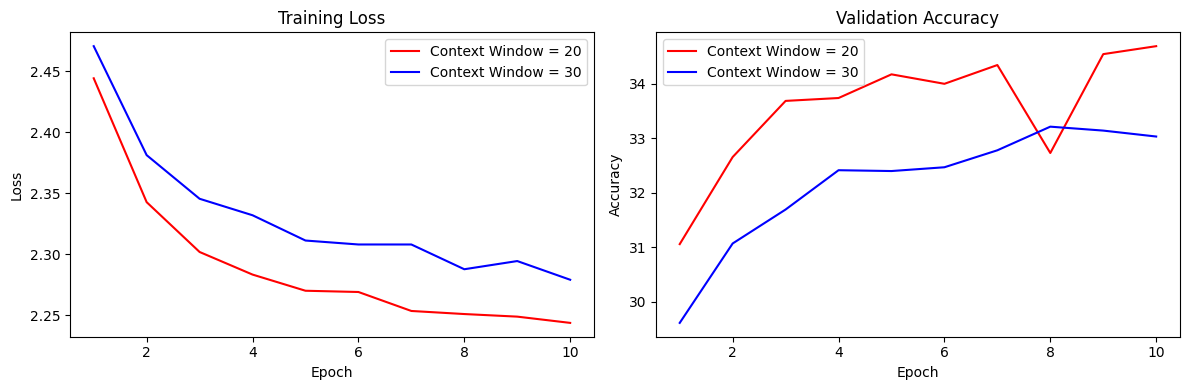

In [20]:
epochs_range = range(1, epochs + 1)
# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses[0], label='Context Window = 20', color = 'red')
plt.plot(epochs_range, training_losses[1], label='Context Window = 30', color = 'blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, validation_accuracies[0], label='Context Window = 20', color = 'red')
plt.plot(epochs_range, validation_accuracies[1], label='Context Window = 30', color = 'blue')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<t>2.2) Adjust the hyperparameters (number of layers, hidden size, and the number of heads) and compare your results (training and validation loss, computation complexity, model size, training and inference time, and the output sequence). Analyze their influence on accuracy, running time, and computational perplexity.</t>

In [21]:
context_window = [20, 30]

learning_rate = 0.001
epochs = 10

hidden_size = 128
num_layers = 8
nhead = 4

models = []
training_losses, validation_accuracies = [], []
training_times, validation_times = [], []

for k in range(len(context_window)):
    model = OptimusTransformer(input_size=vocab_size, hidden_size=hidden_size, output_size=vocab_size, num_layers=num_layers, nhead=nhead).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    training_loader, validation_loader = prepare_data(encoded_text, context_window, k, batch_size = 32)

    train_loss, valid_accuracy, training_time, validation_time = train_model(model, criterion, optimizer, epochs, training_loader, validation_loader, update_interval=1)
    
    models.append(model)
    
    training_losses.append(train_loss)
    validation_accuracies.append(valid_accuracy)
    
    training_times.append(training_time)
    validation_times.append(validation_time)

Epoch   1, Time (secs) 442.36: Training loss 3.3218, Validation Accuracy 15.15%
Epoch   2, Time (secs) 885.49: Training loss 3.3167, Validation Accuracy 15.15%
Epoch   3, Time (secs) 1335.70: Training loss 3.3158, Validation Accuracy 15.15%
Epoch   4, Time (secs) 1776.92: Training loss 3.3154, Validation Accuracy 15.15%
Epoch   5, Time (secs) 2219.01: Training loss 3.3150, Validation Accuracy 15.15%
Epoch   6, Time (secs) 2659.58: Training loss 3.3148, Validation Accuracy 15.15%
Epoch   7, Time (secs) 3093.96: Training loss 3.3147, Validation Accuracy 15.15%
Epoch   8, Time (secs) 3527.78: Training loss 3.3146, Validation Accuracy 15.15%
Epoch   9, Time (secs) 3961.48: Training loss 3.3145, Validation Accuracy 15.15%
Epoch  10, Time (secs) 4395.56: Training loss 3.3143, Validation Accuracy 15.15%

Total Duration: 4395.56s
Training Duration: 414.73s
Inference Duration: 19.34s

Final Training Loss: 3.3143
Final Validation Accuracy: 15.15%

Epoch   1, Time (secs) 432.19: Training loss 3.3

In [22]:
Model0_stats = summary(models[0], (context_window[0], vocab_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()
Model1_stats = summary(models[1], (context_window[1], vocab_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()

print(f'\n========================================= Total Time per Model =========================================')
print(f'Model with Context of 20 Training Duration: {training_times[0]:.2f}s, Inference Duration: \t{validation_times[0]:.2f}s')
print(f'Model with Context of 30 Training Duration: {training_times[1]:.2f}s, Inference Duration: \t{validation_times[1]:.2f}s')
print(f'========================================================================================================')

print(f'\n========================================= Accuracies per Model =========================================')
print(f'Model with Context of 20  Training Loss: {training_losses[0][-1]:.4f}, Inference Accuracy: {validation_accuracies[0][-1]:.2f}%')
print(f'Model with Context of 30  Training Loss: {training_losses[1][-1]:.4f}, Inference Accuracy: {validation_accuracies[1][-1]:.2f}%')
print(f'========================================================================================================')

Layer (type (var_name))                            Kernel Shape     Output Shape     Param #          Mult-Adds
OptimusTransformer (OptimusTransformer)            --               [20, 65]         --               --
├─Embedding (embedding)                            --               [20, 65, 128]    8,320            166,400
│    └─weight                                      [128, 65]                         └─8,320
├─TransformerEncoder (transformer_encoder)         --               [20, 65, 128]    --               --
│    └─layers.0.self_attn.in_proj_weight           [384, 128]                        ├─49,152
│    └─layers.0.self_attn.in_proj_bias             [384]                             ├─384
│    └─layers.0.self_attn.out_proj.weight          [128, 128]                        ├─16,384
│    └─layers.0.self_attn.out_proj.bias            [128]                             ├─128
│    └─layers.0.linear1.weight                     [2048, 128]                       ├─262,144
│    └─lay

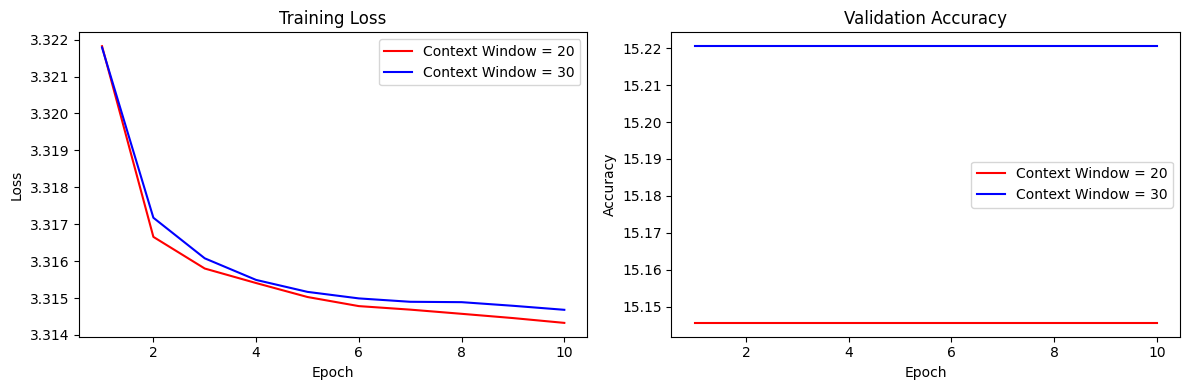

In [23]:
epochs_range = range(1, epochs + 1)
# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses[0], label='Context Window = 20', color = 'red')
plt.plot(epochs_range, training_losses[1], label='Context Window = 30', color = 'blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, validation_accuracies[0], label='Context Window = 20', color = 'red')
plt.plot(epochs_range, validation_accuracies[1], label='Context Window = 30', color = 'blue')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<t>2.3) What if we increase the sequence length to 50. Perform the training and report the accuracy and model complexity results.</t>

In [24]:
context_window = [25, 50]

learning_rate = 0.001
epochs = 10

hidden_size = 128
num_layers = 3
nhead = 2


models = []
training_losses, validation_accuracies = [], []
training_times, validation_times = [], []

for k in range(len(context_window)):
    model = OptimusTransformer(input_size=vocab_size, hidden_size=hidden_size, output_size=vocab_size, num_layers=num_layers, nhead=nhead).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    training_loader, validation_loader = prepare_data(encoded_text, context_window, k, batch_size = 32)

    train_loss, valid_accuracy, training_time, validation_time = train_model(model, criterion, optimizer, epochs, training_loader, validation_loader, update_interval=1)
    
    models.append(model)

    training_losses.append(train_loss)
    validation_accuracies.append(valid_accuracy)
    
    training_times.append(training_time)
    validation_times.append(validation_time)

Epoch   1, Time (secs) 189.09: Training loss 2.4580, Validation Accuracy 30.08%
Epoch   2, Time (secs) 378.43: Training loss 2.3597, Validation Accuracy 31.77%
Epoch   3, Time (secs) 567.52: Training loss 2.3296, Validation Accuracy 32.67%
Epoch   4, Time (secs) 756.15: Training loss 2.3091, Validation Accuracy 32.66%
Epoch   5, Time (secs) 946.75: Training loss 2.2981, Validation Accuracy 30.26%
Epoch   6, Time (secs) 1136.01: Training loss 2.2916, Validation Accuracy 33.03%
Epoch   7, Time (secs) 1325.13: Training loss 2.2821, Validation Accuracy 33.38%
Epoch   8, Time (secs) 1514.16: Training loss 2.2707, Validation Accuracy 33.45%
Epoch   9, Time (secs) 1702.95: Training loss 2.2701, Validation Accuracy 33.37%
Epoch  10, Time (secs) 1895.13: Training loss 2.2747, Validation Accuracy 33.57%

Total Duration: 1895.13s
Training Duration: 181.91s
Inference Duration: 10.27s

Final Training Loss: 2.2747
Final Validation Accuracy: 33.57%

Epoch   1, Time (secs) 196.38: Training loss 2.4965

In [25]:
Model0_stats = summary(models[0], (context_window[0], vocab_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()
Model1_stats = summary(models[1], (context_window[1], vocab_size), dtypes=[torch.long], verbose=2, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"], row_settings=["var_names"])
print()

print(f'\n========================================= Total Time per Model =========================================')
print(f'Model with Context of 25 Training Duration: {training_times[0]:.2f}s, Inference Duration: \t{validation_times[0]:.2f}s')
print(f'Model with Context of 50 Training Duration: {training_times[1]:.2f}s, Inference Duration: \t{validation_times[1]:.2f}s')
print(f'========================================================================================================')

print(f'\n========================================= Accuracies per Model =========================================')
print(f'Model with Context of 25  Training Loss: {training_losses[0][-1]:.4f}, Inference Accuracy: {validation_accuracies[0][-1]:.2f}%')
print(f'Model with Context of 50  Training Loss: {training_losses[1][-1]:.4f}, Inference Accuracy: {validation_accuracies[1][-1]:.2f}%')
print(f'========================================================================================================')

Layer (type (var_name))                            Kernel Shape     Output Shape     Param #          Mult-Adds
OptimusTransformer (OptimusTransformer)            --               [25, 65]         --               --
├─Embedding (embedding)                            --               [25, 65, 128]    8,320            208,000
│    └─weight                                      [128, 65]                         └─8,320
├─TransformerEncoder (transformer_encoder)         --               [25, 65, 128]    --               --
│    └─layers.0.self_attn.in_proj_weight           [384, 128]                        ├─49,152
│    └─layers.0.self_attn.in_proj_bias             [384]                             ├─384
│    └─layers.0.self_attn.out_proj.weight          [128, 128]                        ├─16,384
│    └─layers.0.self_attn.out_proj.bias            [128]                             ├─128
│    └─layers.0.linear1.weight                     [2048, 128]                       ├─262,144
│    └─lay

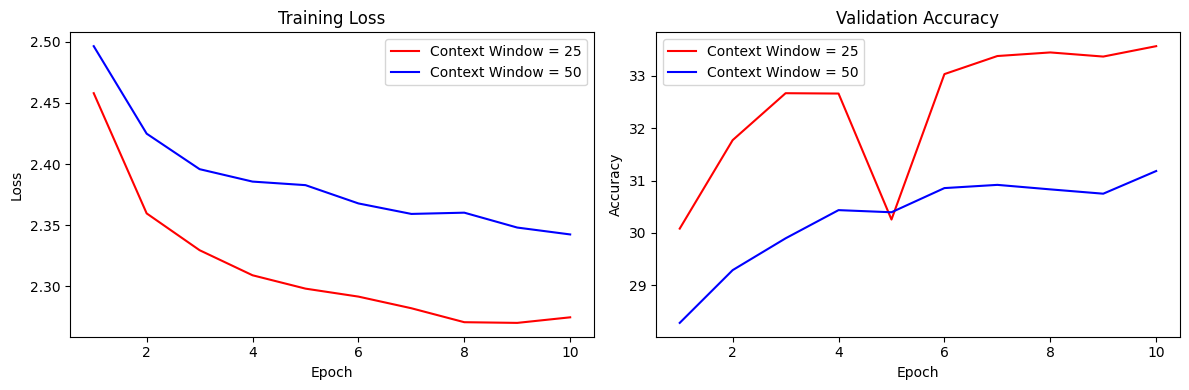

In [26]:
epochs_range = range(1, epochs + 1)
# Plot Training Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses[0], label='Context Window = 25', color = 'red')
plt.plot(epochs_range, training_losses[1], label='Context Window = 50', color = 'blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, validation_accuracies[0], label='Context Window = 25', color = 'red')
plt.plot(epochs_range, validation_accuracies[1], label='Context Window = 50', color = 'blue')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()